## Run community detection experiments

Do this for algorithms:
* planted partition or SBM
* Louvain

And hopefully eADAGE & coexpression networks, if time...

In [28]:
import os

import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
import seaborn as sns

from sample_nodes import sample_degree_matched

np.random.seed(42)
gt.seed_rng(42)

In [2]:
# relevant file paths
data_dir = './data'
processed_graph = os.path.join(data_dir, 'eadage_generic_graph.gt')

In [3]:
G = gt.load_graph(processed_graph)
# make sure vertex/edge properties exist
print(G)
print(list(G.vp.keys()))
print(list(G.ep.keys()))

<Graph object, undirected, with 3477 vertices and 31556 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f3a4c3d9dc0>
['name', 'generic']
['weight']


In [4]:
# community detection using planted partition model
state = gt.PPBlockState(G)
state.multiflip_mcmc_sweep(beta=np.inf, niter=1000)

(-62639.41206195214, 2840780, 161389)

In [5]:
print('k = {}'.format(state.get_B()))

k = 64


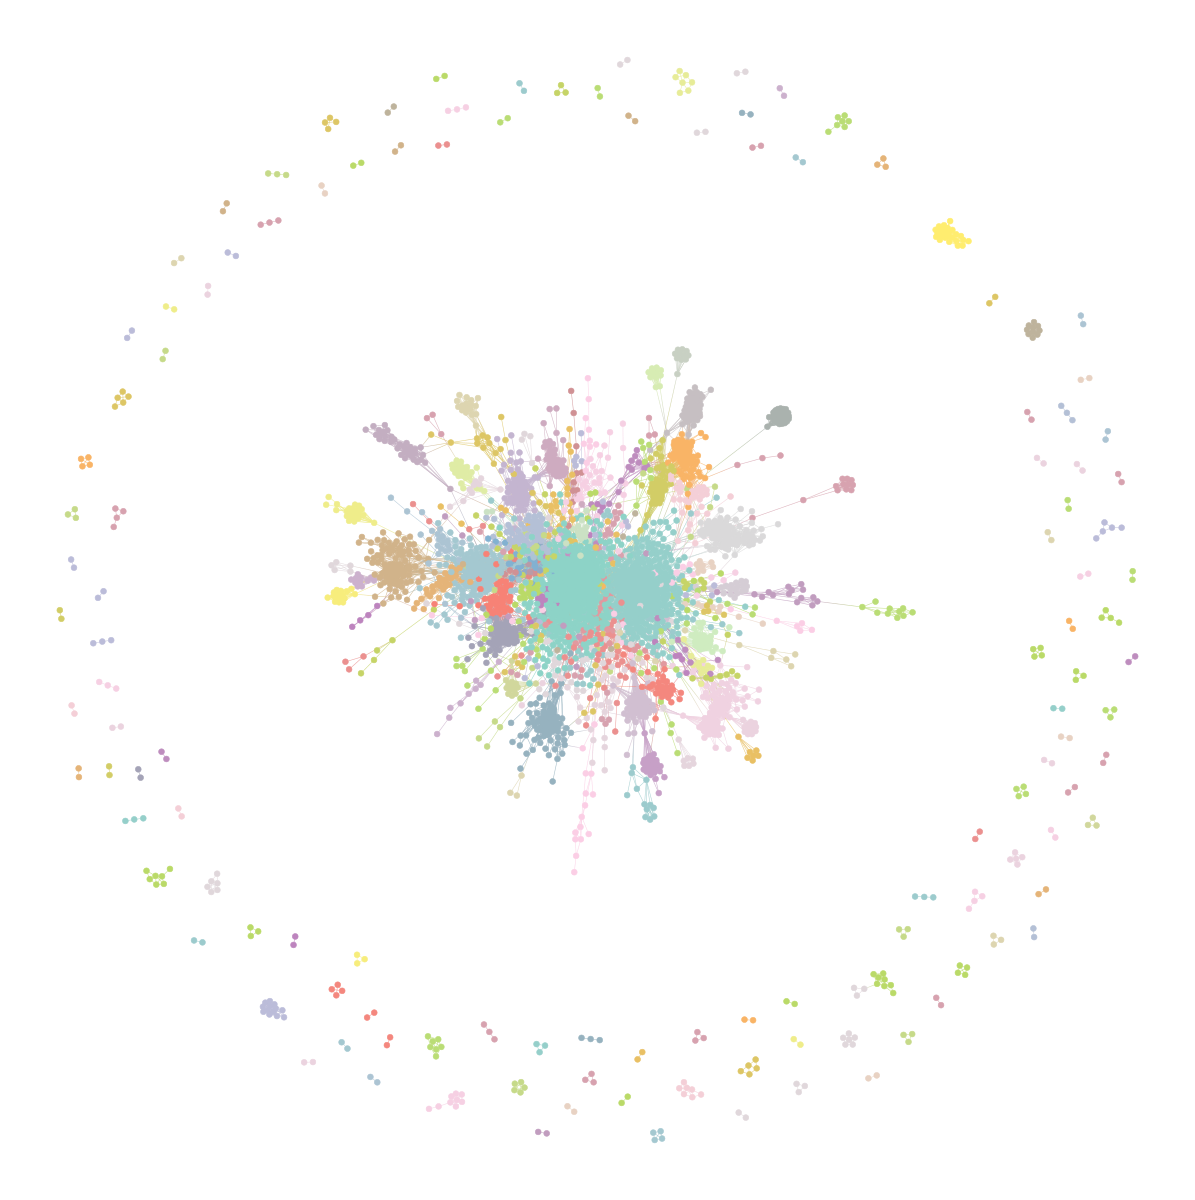

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3a4c3c1c70, at 0x7f3a4c3c8610>

In [6]:
state.draw()

In [24]:
# get dataframe mapping Pa genes to communities
def graph_state_to_df(G, state):
    labels = state.get_blocks().get_array()
    vs = G.get_vertices()
    names = [G.vp['name'][v] for v in vs]
    degrees = G.get_total_degrees(vs)
    is_generic = [G.vp['generic'][v] for v in vs]
    return pd.DataFrame({
        'gene': names,
        'label': labels,
        'degree': degrees,
        'is_generic': is_generic
    })

labels_df = graph_state_to_df(G, state)
print(labels_df.label.unique())
print(len(labels_df.label.unique()))
labels_df.sort_values(by='degree', ascending=False).head(20)

[1969  467 2991  537 1930  562  237 1364 1505 2877 2200  931  814    9
 3147 2008 2423 2039    0 1359  839 2535 1742 1306 2031  361 1437 2790
  450  386 1677 1684 3445 1921 1179 1465 3069 2438  914 2112 1331 3093
  481 3355 1430 2114  908 3032 1000 1195 1640 1091   32 3182  591   33
 2945 2675 2366   54 2744 2952  264  436]
64


,gene,label,degree,is_generic
26,PA4238,1969,209,0
29,PA4245,1969,201,0
30,PA4247,1969,192,0
79,PA4252,1969,181,0
27,PA4239,1969,180,0
17,PA1588,1969,177,0
28,PA4241,1969,171,0
635,PA4265,1969,168,0
630,PA4246,1969,164,0
34,PA4272,1969,163,0


In [30]:
# simultaneously sort nodes and degrees by degree, ascending
nodes, degrees, is_generic = zip(*sorted(
    zip(labels_df.gene.values,
        labels_df.degree.values,
        labels_df.is_generic.values),
    key=lambda x: x[1]
))
nodes = np.array(nodes)
degrees = np.array(degrees)
is_generic = np.array(is_generic)
print(nodes.shape, degrees.shape, is_generic.shape)
print(nodes[is_generic.astype('bool')][-20:])
print(degrees[is_generic.astype('bool')][-20:])

(3477,) (3477,) (3477,)
['PA3418' 'PA4430' 'PA3723' 'PA5046' 'PA3742' 'PA4269' 'PA3743' 'PA5554'
 'PA4670' 'PA2970' 'PA4255' 'PA3744' 'PA5556' 'PA5316' 'PA4563' 'PA4432'
 'PA3745' 'PA0579' 'PA2966' 'PA4433']
[ 55  57  59  67  71  82  84  96  97 100 102 102 103 104 105 117 124 129
 144 160]


In [33]:
# sample random genes to serve as a null distribution
s_nodes, s_degrees, __ = sample_degree_matched(nodes, degrees, is_generic, num_bins=50)
print(s_nodes[:20])
print(s_degrees[:20])
print(s_nodes[-20:])
print(s_degrees[-20:])

['PA2728' 'PA1034' 'PA0467' 'PA0651' 'PA1200' 'PA1566' 'PA2666' 'PA2313'
 'PA2128' 'PA2605' 'PA3065' 'PA4916' 'PA5497' 'PA5451' 'PA0064' 'PA0465'
 'PA5412' 'PA5039' 'PA1648' 'PA5089']
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2.]
['PA4343' 'PA0336' 'PA3219' 'PA1620' 'PA4406' 'PA1794' 'PA4264' 'PA1802'
 'PA5013' 'PA4406' 'PA1801' 'PA5559' 'PA3686' 'PA4744' 'PA3807' 'PA1588'
 'PA4263' 'PA4268' 'PA4238' 'PA0973']
[ 59.  54.  60.  68.  98.  88. 103. 109.  84.  98.  84.  82.  79.  86.
 107. 177. 151. 129. 209. 139.]


In [36]:
# add sampled genes to labels df
sampled = [1 if g in s_nodes else 0 for g in labels_df.gene]
labels_df['sampled'] = sampled
labels_df.sort_values(by='degree', ascending=False).head(20)

,gene,label,degree,is_generic,sampled
26,PA4238,1969,209,0,1
29,PA4245,1969,201,0,0
30,PA4247,1969,192,0,0
79,PA4252,1969,181,0,0
27,PA4239,1969,180,0,0
17,PA1588,1969,177,0,1
28,PA4241,1969,171,0,0
635,PA4265,1969,168,0,0
630,PA4246,1969,164,0,0
34,PA4272,1969,163,0,0


In [38]:
generic_count_df = labels_df.groupby('label').sum()
print(generic_count_df.shape)
print(np.count_nonzero(generic_count_df.is_generic))
generic_count_df.sort_values(by='is_generic', ascending=False).head(60)

(64, 3)
48


,degree,is_generic,sampled
label,,,
537,2047,55,8
1969,23429,46,53
1306,1742,45,13
591,1158,25,3
3182,489,25,1
9,616,23,0
1364,1247,17,2
562,768,11,7
3093,205,10,0
